# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [200]:
# import libraries
# import pyspark related libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
import pyspark.sql.types as psqt
import pyspark.sql.functions as psqf

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.util import MLUtils



# import pandas, matplotlib, and seaborn for visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime for parsing datetime object
import datetime

from time import time

In [201]:
# create a Spark session

spark = SparkSession.builder.appName("sparkify_churn").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [202]:
data_location = "mini_sparkify_event_data.json"
event = spark.read.json(data_location)
df = event

In [203]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [204]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [205]:
#available page options
# filter for users with blank user id
blank_pages = df.filter(df.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = df.select('page').dropDuplicates()

# find values in all_pages that are not in blank_pages
# these are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

Submit Downgrade
Thumbs Down
Submit Upgrade
NextSong
Roll Advert
Cancel
Downgrade
Logout
Add to Playlist
Save Settings
Add Friend
Cancellation Confirmation
Settings
Thumbs Up
Upgrade


In [206]:
#check the number of user id and number os session id
df.agg(psqf.countDistinct('userId'), psqf.countDistinct('sessionId')).show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   226|                     2354|
+----------------------+-------------------------+



In [207]:
#How many female users do we have in the data set?
df.filter(df.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

104

In [208]:
#How many songs were played from the top 5 played artist?
df.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(5)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
+--------------------+-----------+
only showing top 5 rows



In [209]:
#How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.
# TODO: filter out 0 sum and max sum to get more exact answer

function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.60389072847682|
+------------------+



In [210]:
#df.select('level').distinct().show()
level_counts= df.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count").show()


+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      58338|
| paid|     228162|
+-----+-----------+



In [211]:
df.dtypes
df.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [212]:
page_counts= df.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count").show()
page_events = df.groupby('page').count().sort('count', ascending=False).toPandas().set_index('page')

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     14457|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       924|
| Submit Registration|         5|
|            Settings|      1514|
|               Login|      3241|
|            Register|        18|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1726|
|             Upgrade|       499|
+--------------------+----------+
only showing top 20 rows



Text(0, 0.5, 'Event Name')

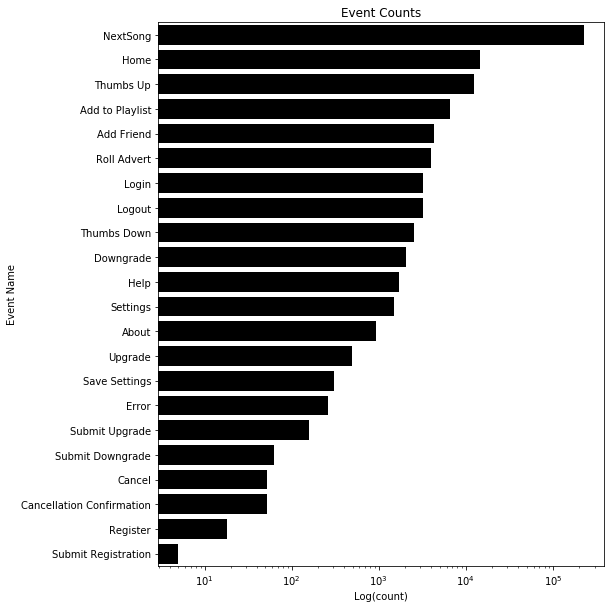

In [213]:
plt.figure(figsize=(8,10))

g = sns.barplot(
    x=page_events['count'],
    y=page_events.index,
    color='black',
    log=True
)

g.set_title('Event Counts')
g.set_xlabel('Log(count)')
g.set_ylabel('Event Name')

In [214]:
df.select('itemInSession').distinct().show() 
df.select('Registration').distinct().show()
df.select('method').distinct().show()

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows

+-------------+
| Registration|
+-------------+
|1529027541000|
|1533192032000|
|1537779419000|
|1534627466000|
|1535389443000|
|1536642109000|
|1537167593000|
|1536854322000|
|1533908361000|
|1536817381000|
|1536663902000|
|1537672236000|
|1536956945000|
|1537611935000|
|1537751138000|
|1533532298000|
|1537057938000|
|1537964483000|
|1528772084000|
|1537440271000|
+-------------+
only showing top 20 rows

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [215]:
cancel_logs = df.filter(psqf.col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID','page', 'firstName', 'lastName','ts', 'auth'])
cancel_logs.show(5, False)

+------+-------------------------+---------+--------+-------------+---------+
|userID|page                     |firstName|lastName|ts           |auth     |
+------+-------------------------+---------+--------+-------------+---------+
|18    |Cancel                   |Adriel   |Mendoza |1538943740000|Logged In|
|18    |Cancellation Confirmation|Adriel   |Mendoza |1538943990000|Cancelled|
|32    |Cancel                   |Diego    |Mckee   |1539033031000|Logged In|
|32    |Cancellation Confirmation|Diego    |Mckee   |1539033046000|Cancelled|
|125   |Cancel                   |Mason    |Hart    |1539318918000|Logged In|
+------+-------------------------+---------+--------+-------------+---------+
only showing top 5 rows



In [216]:
cancel_registration_ids  = [c['userID'] for c in cancel_logs.select('userID').collect()]
print(len(cancel_registration_ids), len(set(cancel_registration_ids)))

104 52


In [217]:
#customer that downgraded
downgrade_logs = df.filter(psqf.col('page').isin(['Downgrade']))
downgrade_logs.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+---------+---------+--------+-------------+---------+
|userID|page     |firstName|lastName|ts           |auth     |
+------+---------+---------+--------+-------------+---------+
|54    |Downgrade|Alexi    |Warren  |1538354749000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538373286000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538392612000|Logged In|
|131   |Downgrade|Kael     |Baker   |1538393618000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538393664000|Logged In|
+------+---------+---------+--------+-------------+---------+
only showing top 5 rows



In [218]:
downgrade_registration_ids  = [c['userID'] for c in downgrade_logs.select('userID').collect()]
print(len(downgrade_registration_ids), len(set(downgrade_registration_ids)))

2055 154


In [219]:
# Now let's see which of those who downgraded also cancel thier subscription by using intersection
downgraded_cancelled = set(cancel_registration_ids).intersection((set(downgrade_registration_ids)))
print('{0:.2f}% of customers who downgraded have also cancelled their subscriptions'.format(
    100*(len(downgraded_cancelled))/len(set(downgrade_registration_ids))))

22.73% of customers who downgraded have also cancelled their subscriptions


In [220]:
df.filter((psqf.col('userID') == list(downgraded_cancelled)[0]) &
                  (psqf.col('page').isin(['Downgrade','Cancel']))).select(['userID','page', 'firstName','ts']).show()

+------+---------+---------+-------------+
|userID|     page|firstName|           ts|
+------+---------+---------+-------------+
|100025|Downgrade|   London|1539928455000|
|100025|Downgrade|   London|1539939105000|
|100025|Downgrade|   London|1539943902000|
|100025|Downgrade|   London|1539943993000|
|100025|Downgrade|   London|1539968727000|
|100025|   Cancel|   London|1540298979000|
+------+---------+---------+-------------+



In [221]:
#convert the timestamps to understand the trend.
ts_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

In [222]:
df = df.select('*').withColumn('ts_datetime', ts_udf(psqf.col('ts')))

In [223]:
df.filter((psqf.col('userID') == list(downgraded_cancelled)[1]) &
                  (psqf.col('page').isin(['Downgrade','Cancel', 'Cancellation Confirmation']))).select(['userID','page', 'firstName','ts', 'ts_datetime']).show(25, False)

+------+-------------------------+---------+-------------+-------------------+
|userID|page                     |firstName|ts           |ts_datetime        |
+------+-------------------------+---------+-------------+-------------------+
|129   |Downgrade                |Davis    |1538896047000|2018-10-07 07:07:27|
|129   |Downgrade                |Davis    |1538911363000|2018-10-07 11:22:43|
|129   |Downgrade                |Davis    |1538923089000|2018-10-07 14:38:09|
|129   |Downgrade                |Davis    |1539010046000|2018-10-08 14:47:26|
|129   |Downgrade                |Davis    |1539347207000|2018-10-12 12:26:47|
|129   |Downgrade                |Davis    |1539362366000|2018-10-12 16:39:26|
|129   |Downgrade                |Davis    |1539367200000|2018-10-12 18:00:00|
|129   |Downgrade                |Davis    |1539736068000|2018-10-17 00:27:48|
|129   |Cancel                   |Davis    |1539736069000|2018-10-17 00:27:49|
|129   |Cancellation Confirmation|Davis    |15397361

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [224]:
#Lets look at the churn log

churn_log = df.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
# define 1 as churned, 0 otherwise
label = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn_log = churn_log.withColumn("label", label(churn_log.pages)).drop('pages')
churn_log.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|   132|    0|
|   154|    0|
|100014|    1|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|    29|    1|
|    69|    0|
|100021|    1|
|   112|    0|
+------+-----+
only showing top 20 rows



In [225]:
#combine the new created churn_tag with the df
dfnew  = churn_log.join(df, 'userId')
dfnew.show(5)

+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+
|userId|label|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|        ts_datetime|
+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+
|100010|    0|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|2018-10-08 12:58:54|
|100010|

In [226]:
churned_count = dfnew.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|241636|
|    1| 44864|
+-----+------+



In [227]:
# number of downgrades for churned vs active users
downgrade_count = dfnew.where((psqf.col("page")=='Downgrade')).groupby("label").agg(psqf.count(psqf.col('page')).alias('downgradeCount'))
downgrade_count.show(5)

+-----+--------------+
|label|downgradeCount|
+-----+--------------+
|    0|          1718|
|    1|           337|
+-----+--------------+



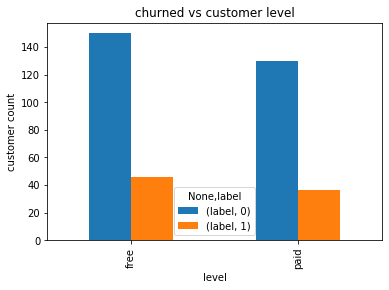

In [228]:
#compare paid vs free against churn tag
use_level_count = dfnew.groupby('userId', 'level', 'label').count()
use_level_count_pd  = use_level_count.select("userId", "level", 'label').toPandas()
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned vs customer level')
plt.ylabel('customer count');

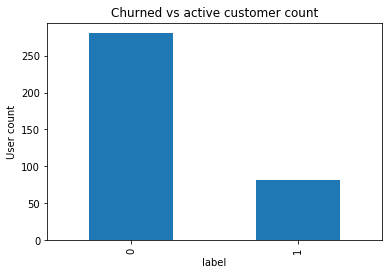

In [229]:
use_level_count_pd.label.value_counts().plot(kind='bar');
plt.ylabel('User count')
plt.xlabel('label')
plt.title('Churned vs active customer count');

In [230]:
# count downgrade events per user
downgrade_events_user = dfnew.filter(psqf.col('page') == 'Downgrade').groupBy('label','page').count()
downgrade_events_user.show(2)

+-----+---------+-----+
|label|     page|count|
+-----+---------+-----+
|    1|Downgrade|  337|
|    0|Downgrade| 1718|
+-----+---------+-----+



In [231]:
dfnew.groupBy('userId','label','gender').count().select('label', 'gender').groupBy('label','gender').count().show()

+-----+------+-----+
|label|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|  null|    1|
|    1|     M|   32|
|    0|     F|   84|
|    1|     F|   20|
+-----+------+-----+



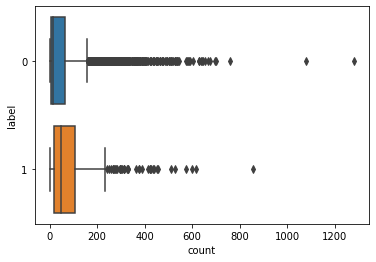

In [232]:
#show the distribution of operations 0 = active, 1 churn
dfchurn = dfnew.groupby("label", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='label', orient="h", data=dfchurn)

In [233]:
# Number of songs each user played
songsplayed = dfnew.where(psqf.col('song')!='null').groupby("userId").agg(psqf.count(psqf.col('song')).alias('SongsPlayed')).orderBy('userId')
songsplayed.show(5)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



In [234]:
# Number of hours a customer logged in the system
hours_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d-%H'))
hours_df  = dfnew.select('userId', 'ts').withColumn('hour', hours_udf(psqf.col('ts')))
hours_df.show(5)

+------+-------------+-------------+
|userId|           ts|         hour|
+------+-------------+-------------+
|100010|1539003534000|2018-10-08-12|
|100010|1539003736000|2018-10-08-13|
|100010|1539003932000|2018-10-08-13|
|100010|1539003933000|2018-10-08-13|
|100010|1539004195000|2018-10-08-13|
+------+-------------+-------------+
only showing top 5 rows



In [235]:
# Now group by Hour to see how many hours a user was logged in
hour_count_df = hours_df.where(psqf.col('userId')!='null').groupby('userId').agg((psqf.countDistinct(psqf.col('hour'))).alias("HourCount")).orderBy('userId')
hour_count_df.show(5)

+------+---------+
|userId|HourCount|
+------+---------+
|      |     1306|
|    10|       51|
|   100|      218|
|100001|       14|
|100002|       18|
+------+---------+
only showing top 5 rows



In [236]:
# filter out rows with userId == null
dfnew = dfnew.where(psqf.col('userId')!='null')
dfnew.show(5)

+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+
|userId|label|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|        ts_datetime|
+------+-----+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+
|100010|    0|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|2018-10-08 12:58:54|
|100010|

In [237]:
thumbsup_count = dfnew.where((psqf.col('page')=='Thumbs Up') &(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount')).orderBy('userId')
thumbsup_count.show(5, False)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|10    |37           |
|100   |148          |
|100001|8            |
|100002|5            |
|100003|3            |
+------+-------------+
only showing top 5 rows



In [238]:
thumbsdown_count = dfnew.where((psqf.col("page")=='Thumbs Down')&(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount')).orderBy('userId')
thumbsdown_count.show(5)

+------+---------------+
|userId|thumbsDownCount|
+------+---------------+
|    10|              4|
|   100|             27|
|100001|              2|
|100004|             11|
|100005|              3|
+------+---------------+
only showing top 5 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [239]:
## combine all the features
features_df = churn_log.join(songsplayed, "userId").\
join(hour_count_df, "userId").join(thumbsup_count, "userId").join(thumbsdown_count, "userId")
features_df.show(5)

+------+-----+-----------+---------+-------------+---------------+
|userId|label|SongsPlayed|HourCount|thumbsUpCount|thumbsDownCount|
+------+-----+-----------+---------+-------------+---------------+
|100010|    0|        275|       26|           17|              5|
|200002|    0|        387|       32|           21|              6|
|   124|    0|       4079|      306|          171|             41|
|    51|    1|       2111|      156|          100|             21|
|     7|    0|        150|       18|            7|              1|
+------+-----+-----------+---------+-------------+---------------+
only showing top 5 rows



In [240]:
assembler = VectorAssembler(inputCols=["SongsPlayed", "HourCount", "thumbsUpCount", "thumbsDownCount"], outputCol="rawFeatures")
features_df = assembler.transform(features_df)
features_df.select('label', 'rawFeatures').show(4)

+-----+--------------------+
|label|         rawFeatures|
+-----+--------------------+
|    0|[275.0,26.0,17.0,...|
|    0|[387.0,32.0,21.0,...|
|    0|[4079.0,306.0,171...|
|    1|[2111.0,156.0,100...|
+-----+--------------------+
only showing top 4 rows



In [241]:
scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_df)
features_df = scalerModel.transform(features_df)

In [242]:
input_data = features_df.withColumn('label', psqf.col('label').cast(psqt.IntegerType())).select('label', 'features')
input_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24639992057147...|
|    0|[0.34675188822240...|
+-----+--------------------+
only showing top 2 rows



In [243]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

In [244]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(input_data)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [245]:
# Split the data into training and test sets 
(trainingData, testData) = input_data.randomSplit([0.7, 0.3])


In [246]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)


# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [247]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

In [248]:
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "label", "features").show(10)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
#rfModel = model.stages
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             1|    0|[0.34675188822240...|
|             0|    1|[1.89145539027778...|
|             0|    0|[0.73471976315859...|
|             0|    1|[0.23027192577043...|
|             0|    1|[1.61011148097071...|
|             0|    0|[0.19263993790133...|
|             0|    0|[0.22489592750342...|
|             0|    1|[0.61017580330609...|
|             0|    0|[0.60479980503908...|
|             0|    0|[1.24812759765843...|
+--------------+-----+--------------------+
only showing top 10 rows

Validation Error = 0.261538
RandomForestClassificationModel (uid=RandomForestClassifier_a70490428681) with 10 trees


In [249]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.693215


In [257]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|[0.34675188822240...|
|       0.0|         1.0|[1.89145539027778...|
|       0.0|         0.0|[0.73471976315859...|
|       0.0|         1.0|[0.23027192577043...|
|       0.0|         1.0|[1.61011148097071...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.338462
GBTClassificationModel (uid=GBTClassifier_3e75f109aab8) with 10 trees


In [258]:
f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.642012


In [250]:
rfc = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rfc, labelConverter])
param_grid = ParamGridBuilder().addGrid(rfc.numTrees, [10, 15]).addGrid(rfc.maxDepth, [2, 5]).build()
cv = CrossValidator(estimator=pipeline, 
                    estimatorParamMaps = param_grid, 
                    evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds=3)

best_model = cv.fit(trainingData)

In [251]:
def evaluate_model(model, data):
    """
    Make prediction and evaluate model.
    Parameters
    -----------
        model: model object
    returns
    -------
        None
    """
    predictions = model.transform(data)

    # Select example rows to display.
    predictions.select("predictedLabel", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Error = %g" % (1.0 - accuracy))
    f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
    f1_score = f1_score_evaluator.evaluate(predictions)
    print("F1 score = %g" % (f1_score))

In [254]:
evaluate_model(model=best_model, data=testData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             1|    0|[0.34675188822240...|
|             0|    1|[1.89145539027778...|
|             0|    0|[0.73471976315859...|
|             0|    1|[0.23027192577043...|
|             0|    1|[1.61011148097071...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.261538
F1 score = 0.693215


In [255]:
evaluate_model(model=best_model, data=trainingData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.24639992057147...|
|             0|    0|[0.13439995667535...|
|             0|    0|[3.65478282185840...|
|             0|    0|[1.71494344717749...|
|             0|    1|[2.54553517943116...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.10219
F1 score = 0.890671


In [256]:
evaluate_model(model=best_model, data=features_df)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.24639992057147...|
|             1|    0|[0.34675188822240...|
|             0|    0|[3.65478282185840...|
|             0|    1|[1.89145539027778...|
|             0|    0|[0.13439995667535...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.153465
F1 score = 0.831527


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.